# Linear regression

In [1]:
from IPython import get_ipython
if get_ipython():
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la
la.logger.setLevel("INFO")

## Generative model

In [2]:
n_cells = 50
cell_ids = [str(i) for i in range(n_cells)]
cells = la.Dim(pd.Series(cell_ids, name = "cell"))

x = la.Fixed(pd.Series(np.random.uniform(0, 3, n_cells), index = cells.index), label = "x")

In [3]:
n_genes = 100
genes = la.Dim([str(i) for i in range(n_genes)], id = "gene")

slope = la.Fixed(pd.Series(np.random.choice([-1, 1], n_genes) * np.random.normal(3., 1., n_genes) * (np.random.random(n_genes) > 0.5), index = genes.index), label = "slope")
intercept = la.Fixed(pd.Series(np.random.choice([-1, 1], n_genes) * np.random.normal(3., 1., n_genes) * (np.random.random(n_genes) > 0.5), index = genes.index), label = "intercept")
scale = la.Fixed(pd.Series(np.random.uniform(1., 1.2, n_genes), index = genes.index), label = "scale")

In [4]:
y = la.links.scalar.Linear(x = x, a = slope, b = intercept)
dist = la.distributions.Normal(loc = y, scale = scale)


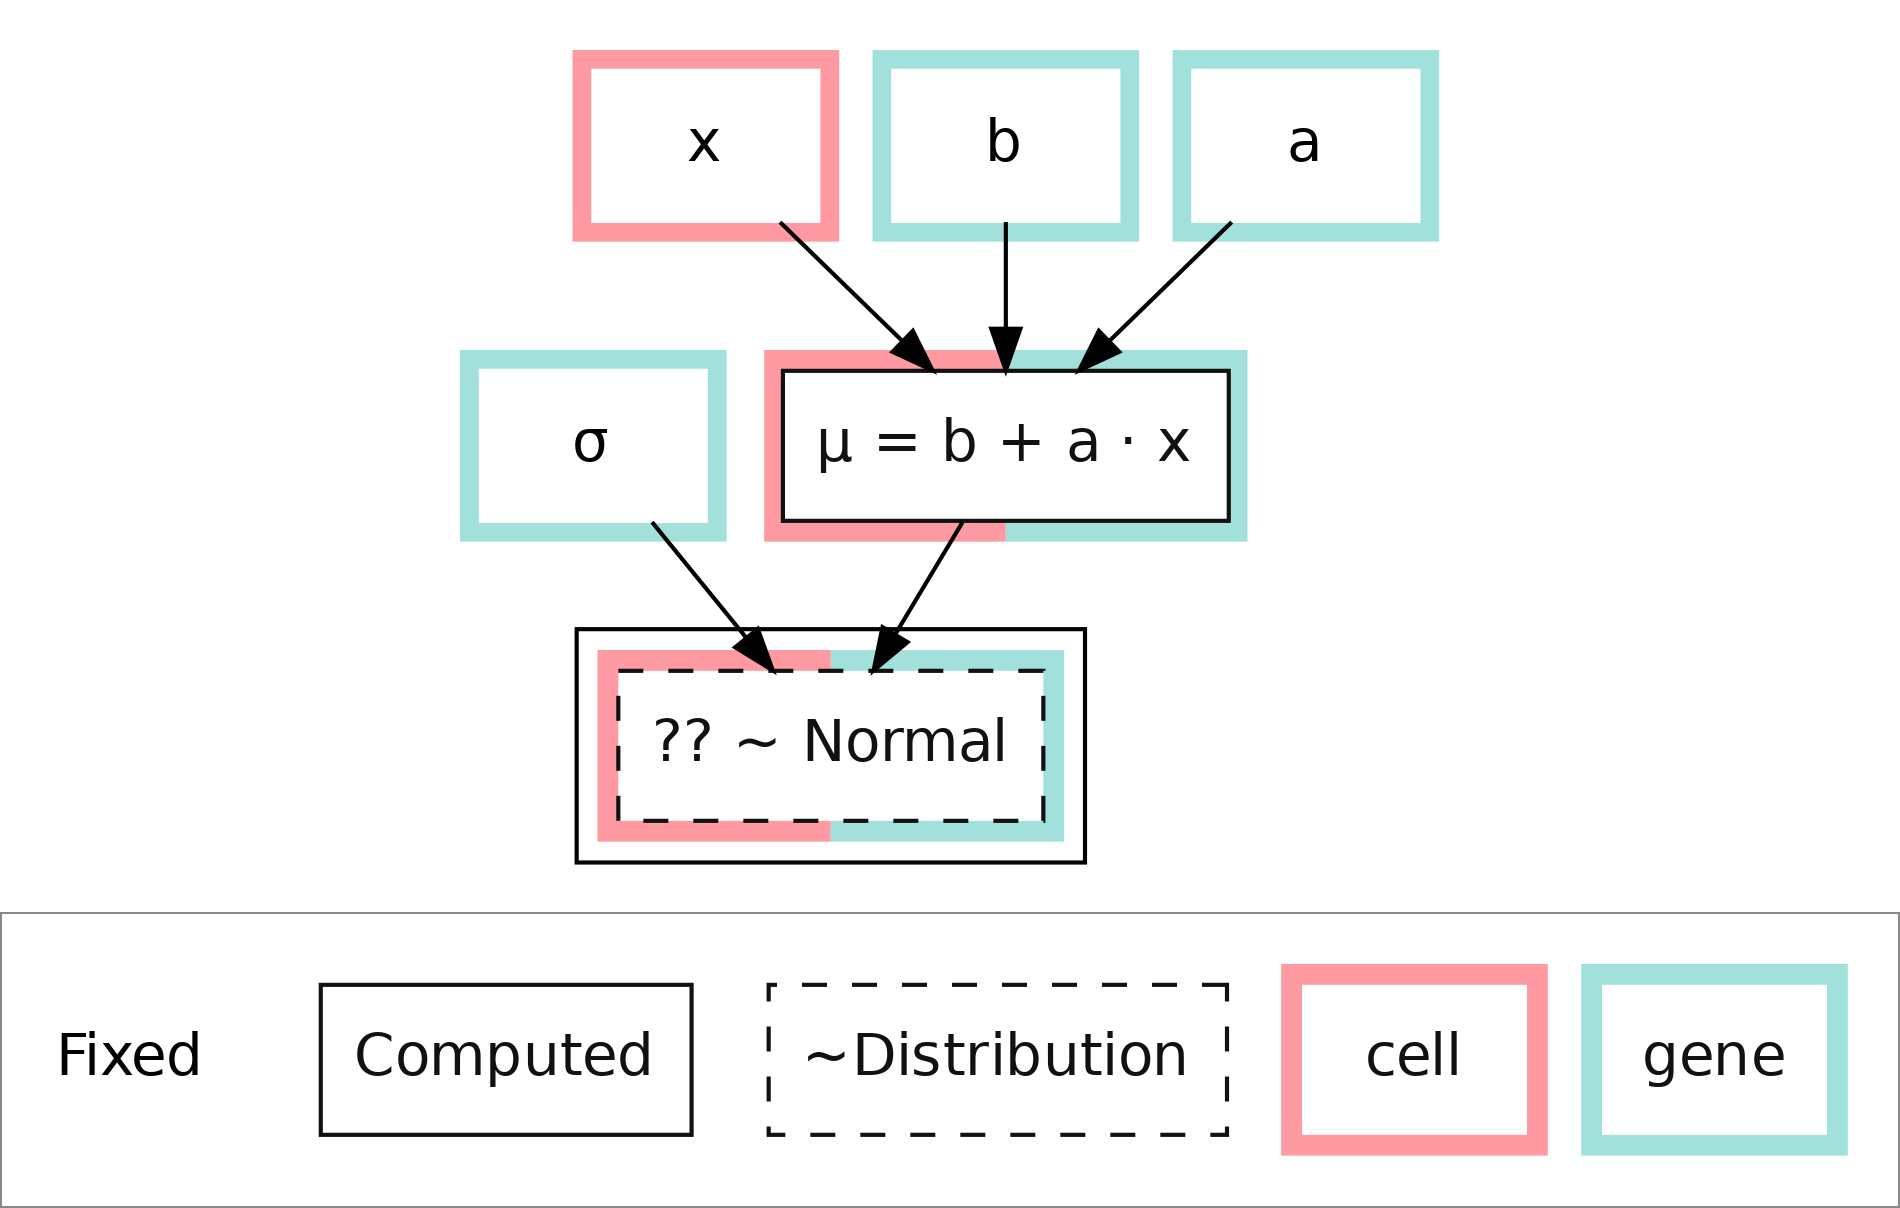

In [5]:
model_gs = la.Model(dist, label = "ground truth", symbol = "gs")
model_gs.plot()

In [6]:
posterior = la.posterior.Posterior(dist)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

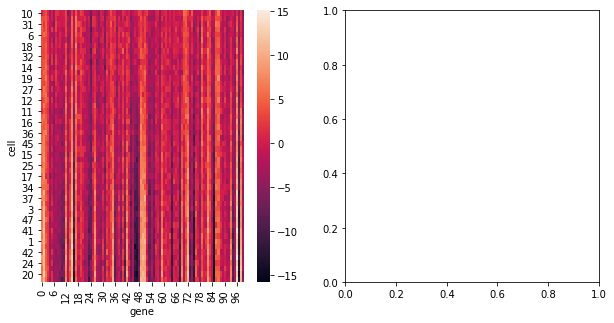

In [7]:
observation_value = posterior.samples[dist].sel(sample = 0).to_pandas()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10, 5))
cell_order = model_gs.find("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax = ax0)

## Linear regression with maximum likelihood

In [8]:
a = la.Parameter(0., definition = slope, transforms = la.distributions.Normal(scale = 1.).biject_to())
b = la.Parameter(0., definition = intercept, transforms = la.distributions.Normal(scale = 1.).biject_to())
s = la.Parameter(1., definition = scale, transforms = la.distributions.Exponential().biject_to())

z = la.links.scalar.Linear(x, a, b)

dist = la.distributions.Normal(loc = z, scale = s)

observation = la.Observation(observation_value, dist, label = "observation")


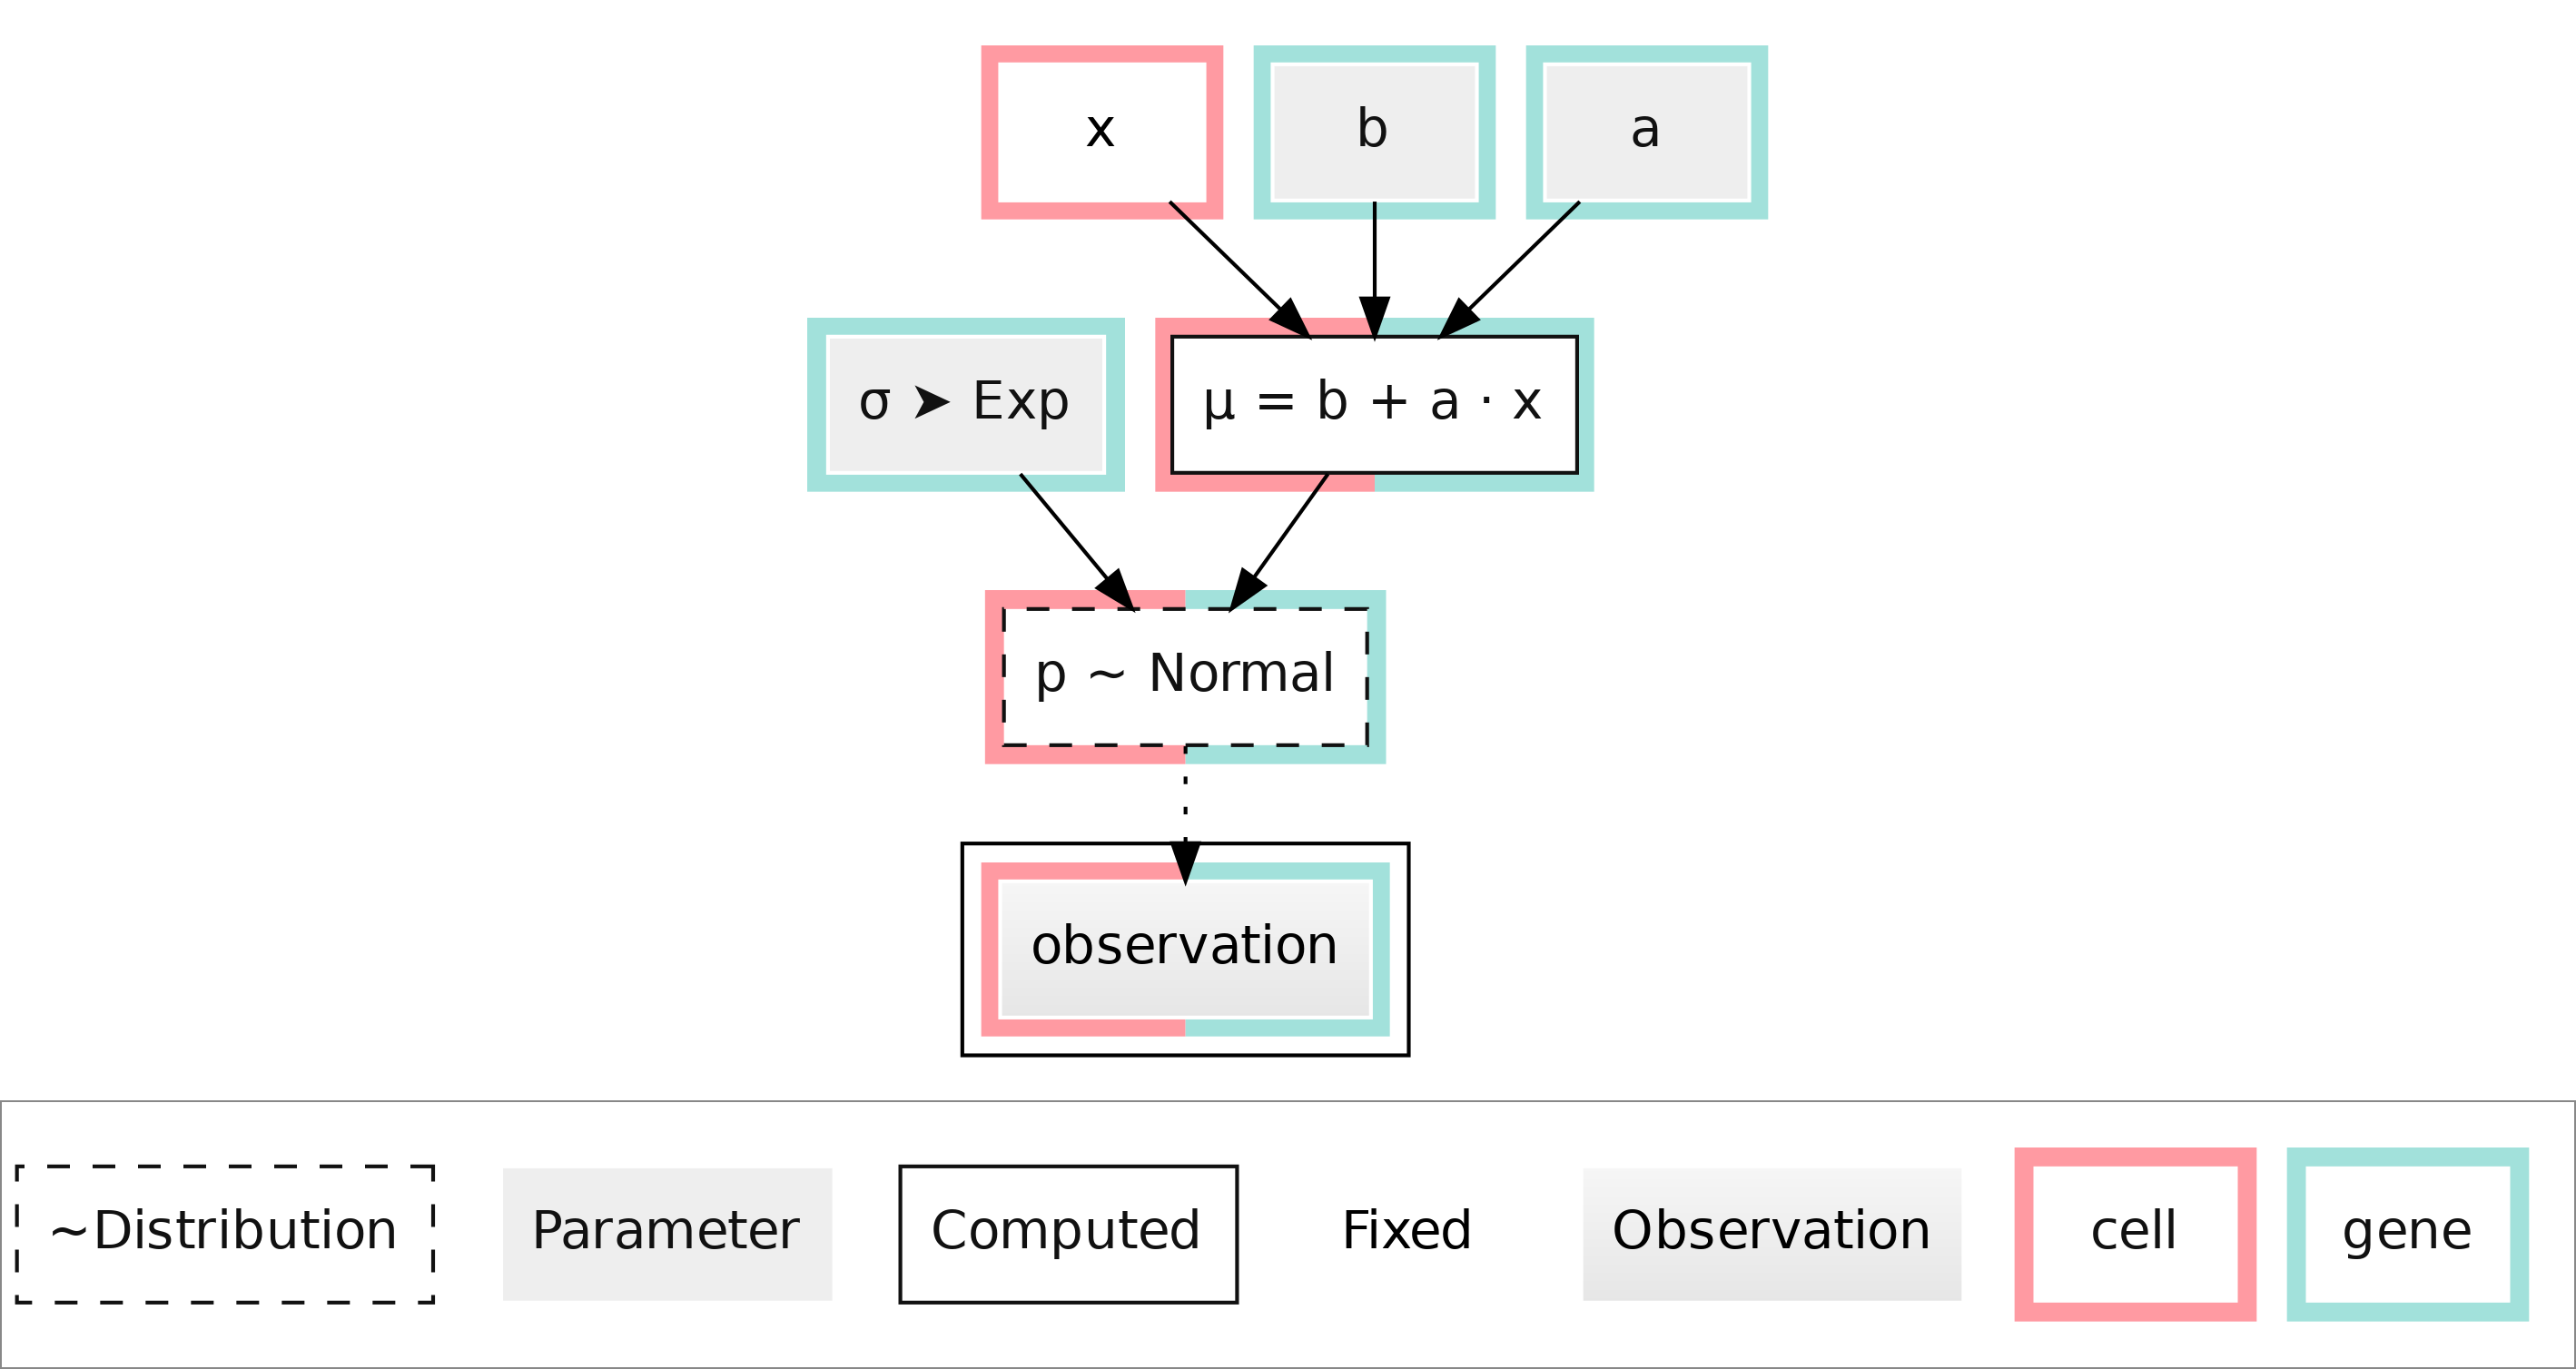

In [9]:
model = la.Model(observation)
model.plot()

  0%|                                                                                                         …

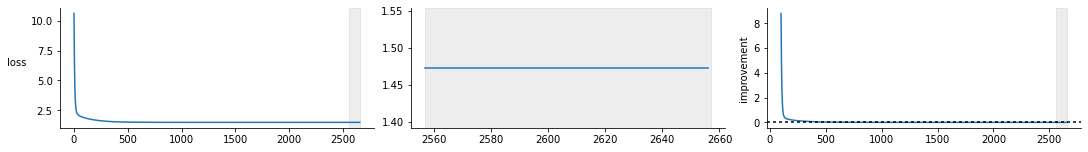

In [10]:
inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.05))
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(3000)
trace.plot();

In [11]:
observed = la.posterior.Posterior(observation)
observed.sample(10, subsample_n = 1)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

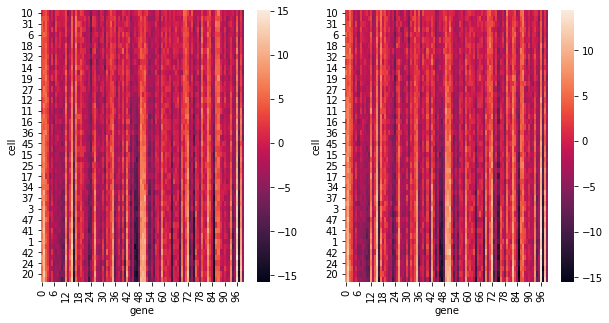

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10, 5))
cell_order = model_gs.find("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax = ax0)
modelled_value = observed.samples[observation.p].sel(sample = 0).to_pandas()
sns.heatmap(modelled_value.loc[cell_order], ax = ax1)

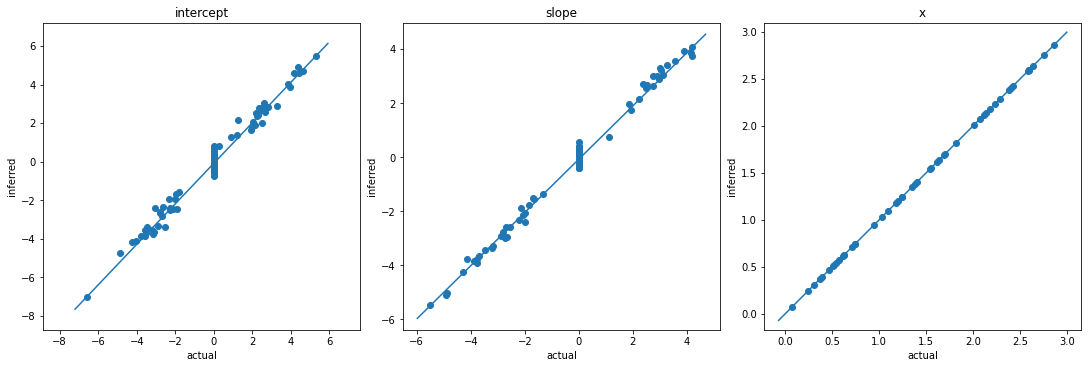

In [13]:
parameter_values = la.qa.cookbooks.check_parameters(la.qa.cookbooks.gather_parameters(["intercept", "slope", "x"], model_gs, observed))

## Linear regression with maximal likelihood and inferred x

In [15]:
x = la.Parameter(0.5, definition = x, transforms = la.distributions.Uniform(0., 1.).biject_to(), label = "x")

In [16]:
a = la.Parameter(0., definition = slope, transforms = la.distributions.Normal(scale = 1.).biject_to())
b = la.Parameter(0., definition = intercept, transforms = la.distributions.Normal(scale = 1.).biject_to())
s = la.Parameter(1., definition = scale, transforms = la.distributions.Exponential().biject_to())

z = la.links.scalar.Linear(x, a, b)

dist = la.distributions.Normal(loc = z, scale = s)

observation = la.Observation(observation_value, dist, label = "observation")


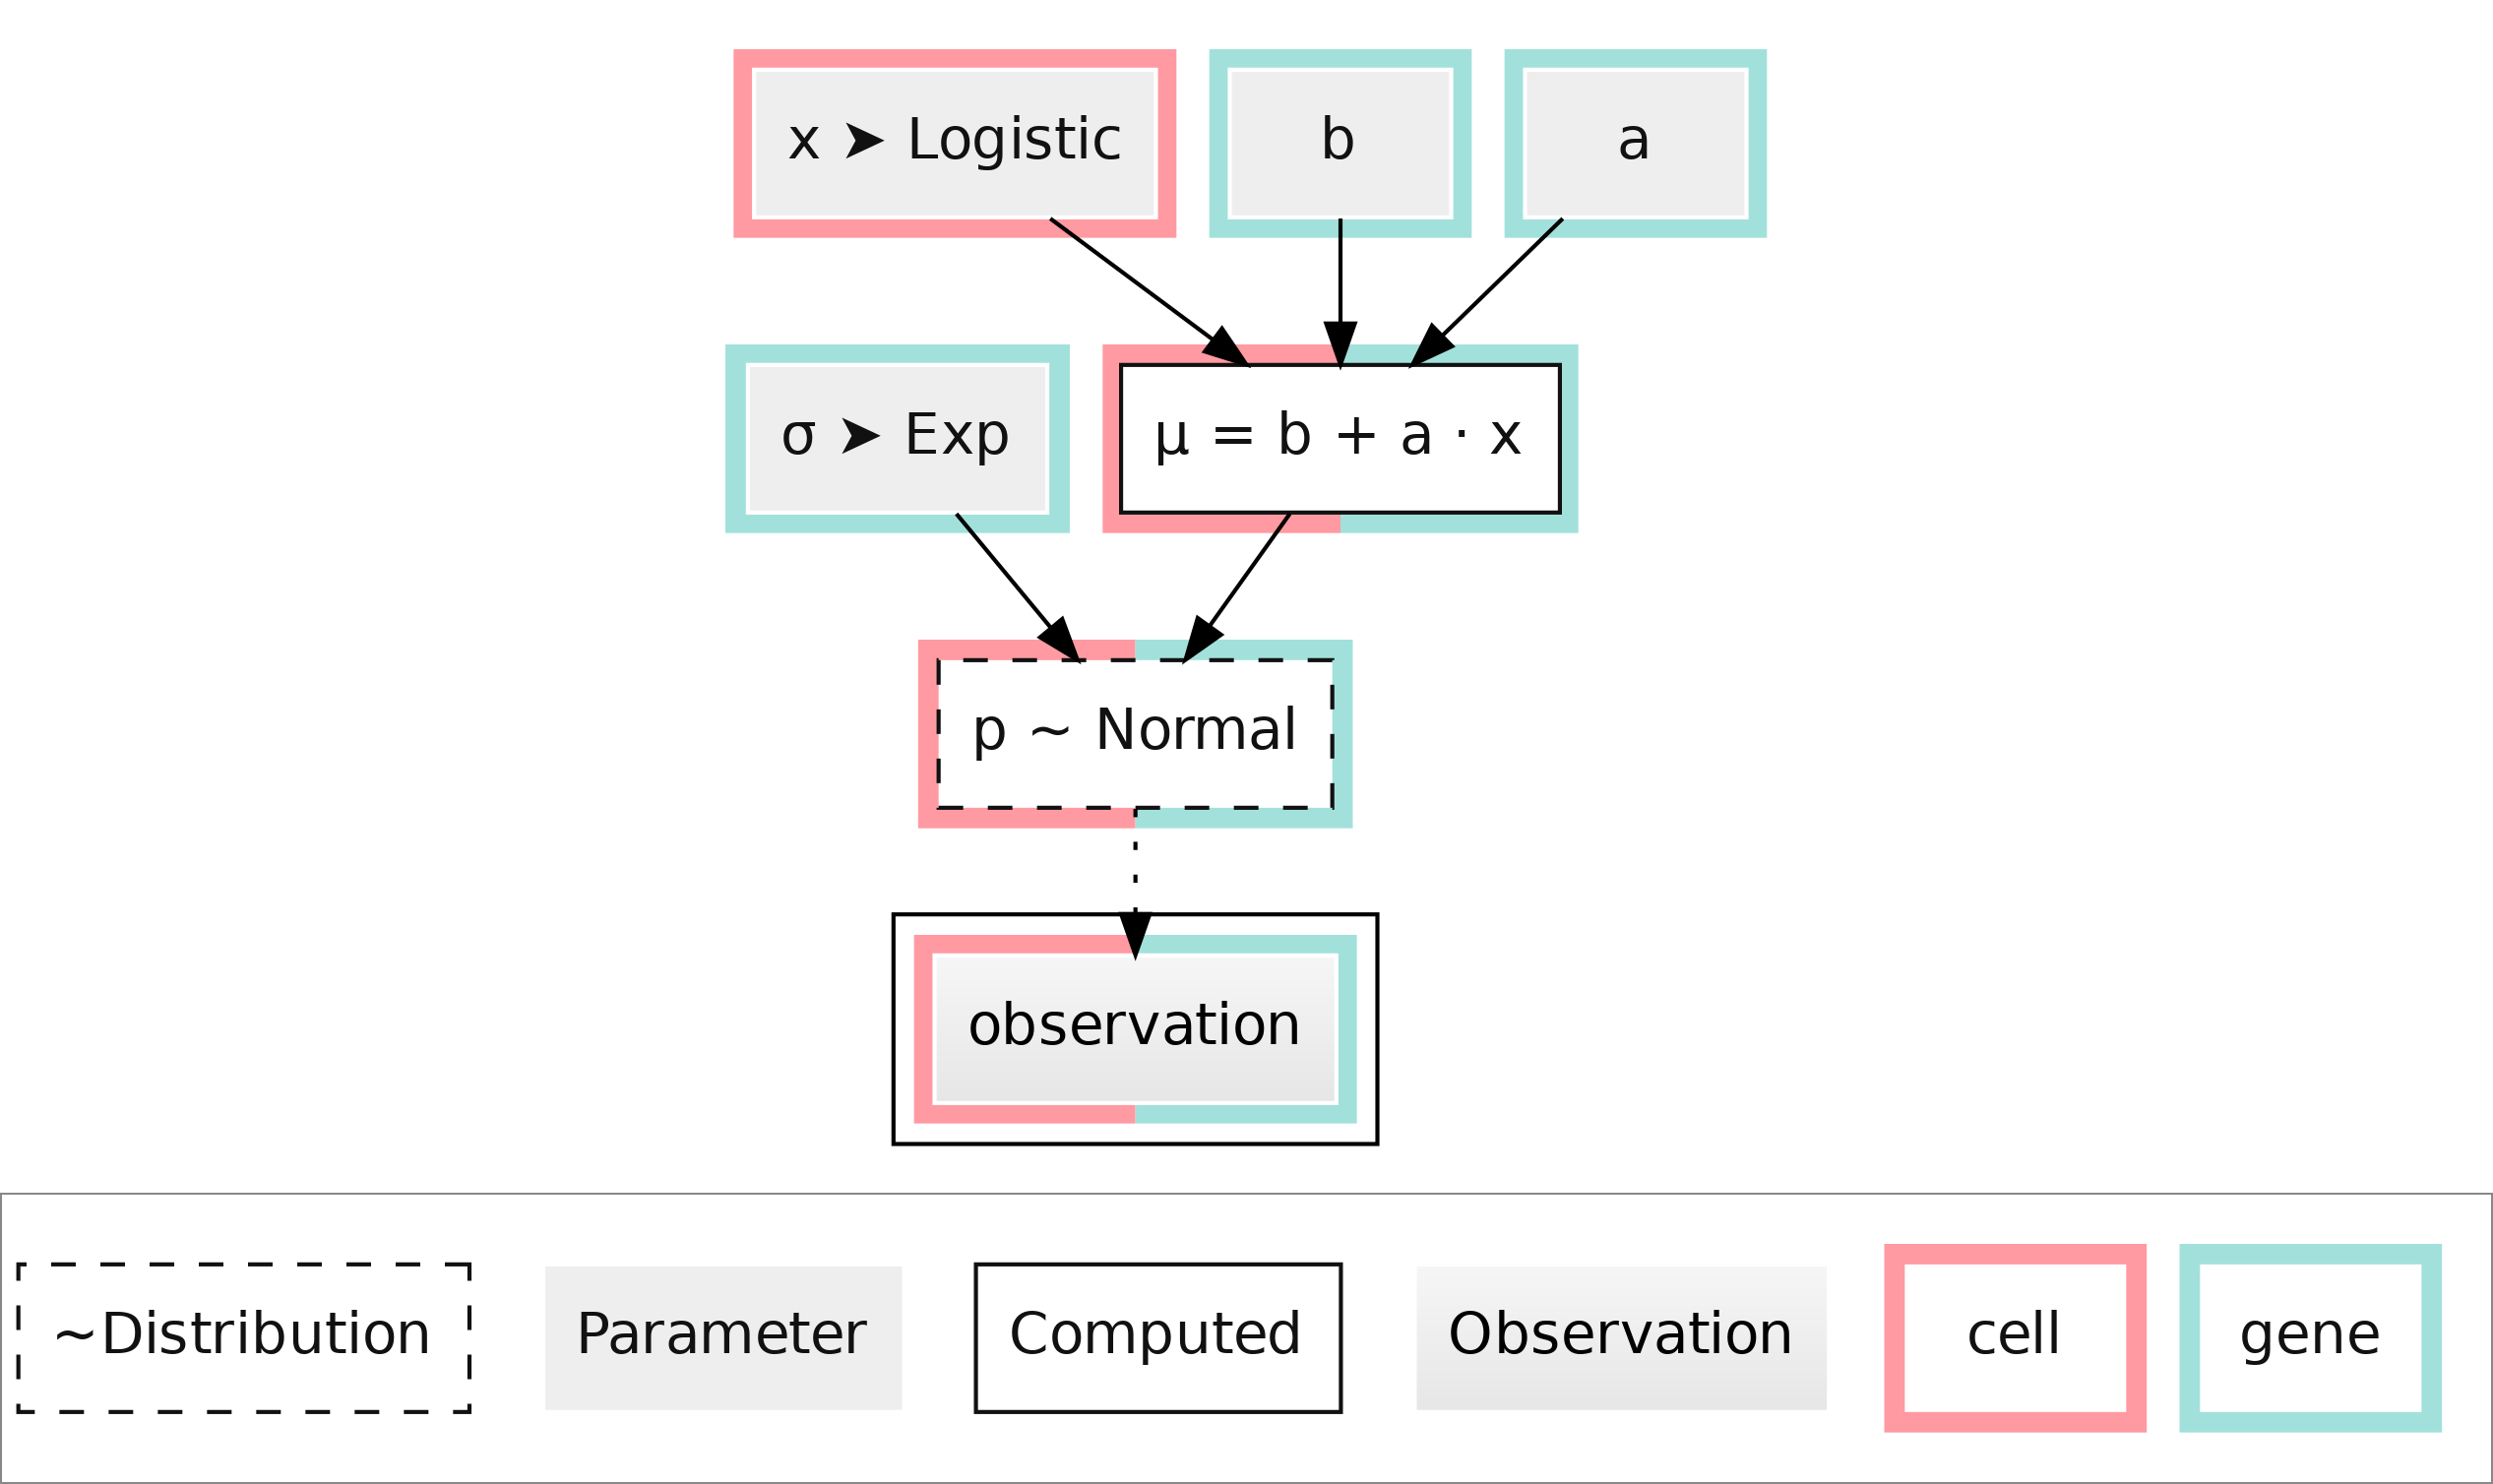

In [17]:
model = la.Model(observation)
model.plot()

  0%|                                                                                                         …

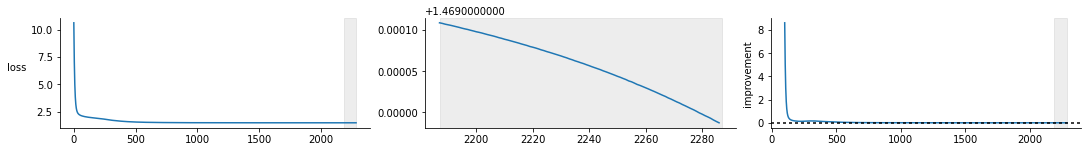

In [18]:
inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.05))
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(3000)
trace.plot();

In [19]:
observed = la.posterior.Posterior(observation)
observed.sample(10, subsample_n = 3)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

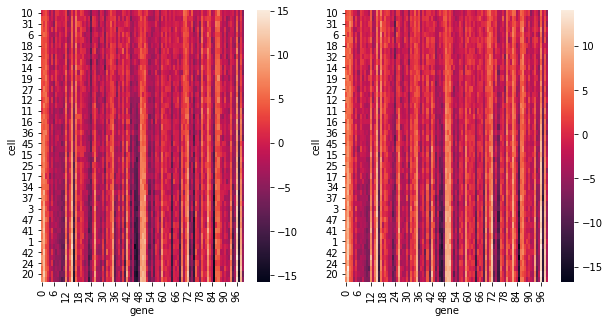

In [20]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10, 5))
cell_order = model_gs.find("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax = ax0)
modelled_value = observed.samples[observation.p].sel(sample = 0).to_pandas()
sns.heatmap(modelled_value.loc[cell_order], ax = ax1)

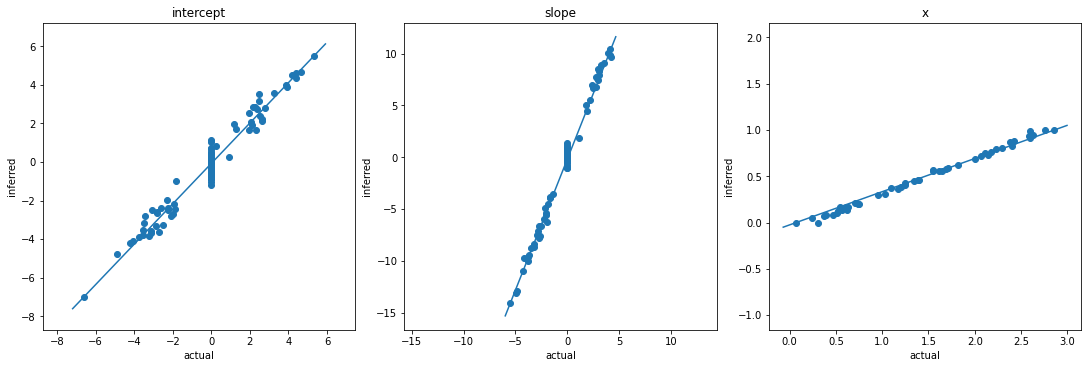

In [21]:
parameter_values = la.qa.cookbooks.check_parameters(la.qa.cookbooks.gather_parameters(["intercept", "slope", "x"], model_gs, observed))

## Linear regression with variational inference and latent x

In [22]:
x = la.Latent(la.distributions.Uniform(0., 3.), definition = la.Definition([cells]), label = "x")

z = la.links.scalar.Linear(x, output = la.Definition([cells, genes]), a = True, b = True)

dist = la.distributions.Normal(loc = z, scale = s)

observation = la.Observation(observation_value, dist, label = "observation")


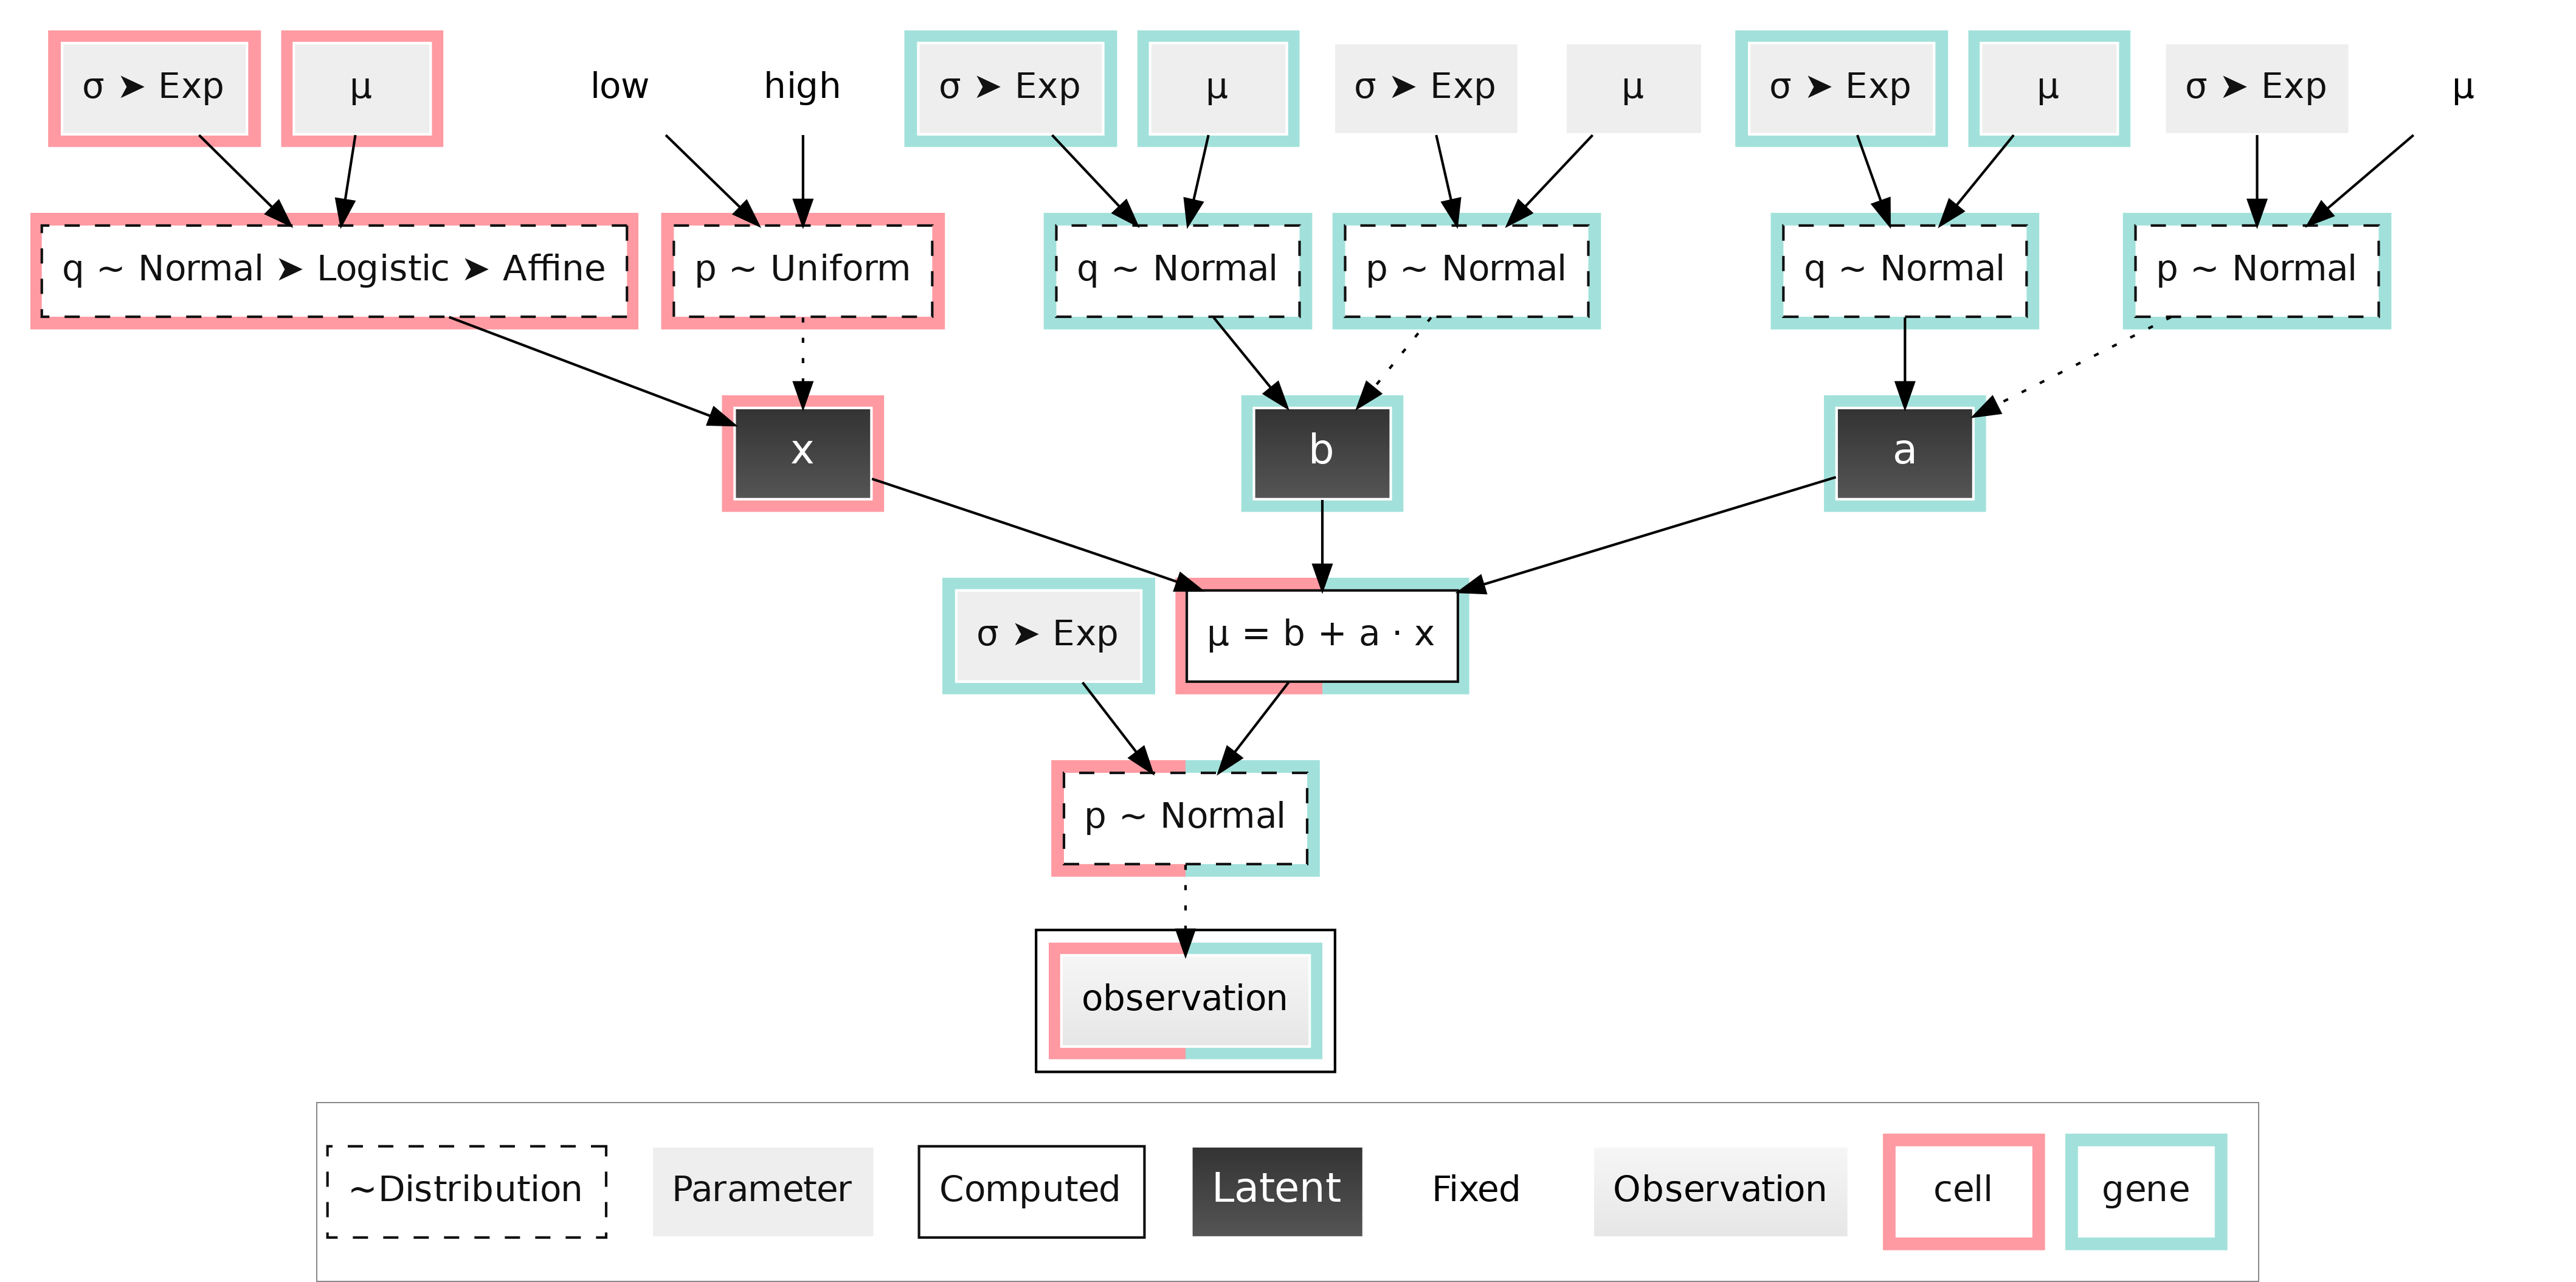

In [23]:
model = la.Model(observation)
model.plot()

  0%|                                                                                                         …

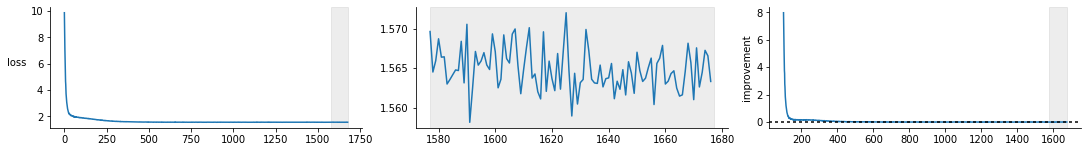

In [24]:
inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.05))
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(3000)
trace.plot();

In [25]:
observation.reset()
observation.run()
observation.p.loc.x.likelihood.sum()

tensor(-54.9306)

In [26]:
observed = la.posterior.Posterior(observation)
observed.sample(10, subsample_n = 4)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

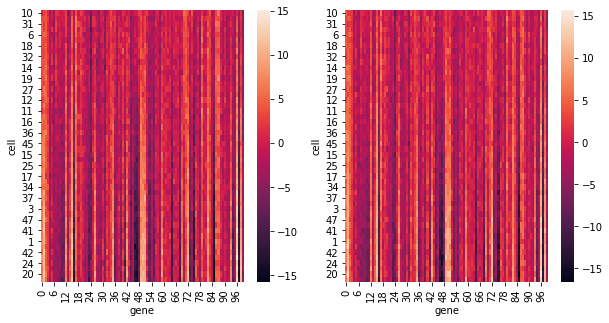

In [27]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10, 5))
cell_order = model_gs.find("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax = ax0)
modelled_value = observed.samples[observation.p].sel(sample = 0).to_pandas()
sns.heatmap(modelled_value.loc[cell_order], ax = ax1)

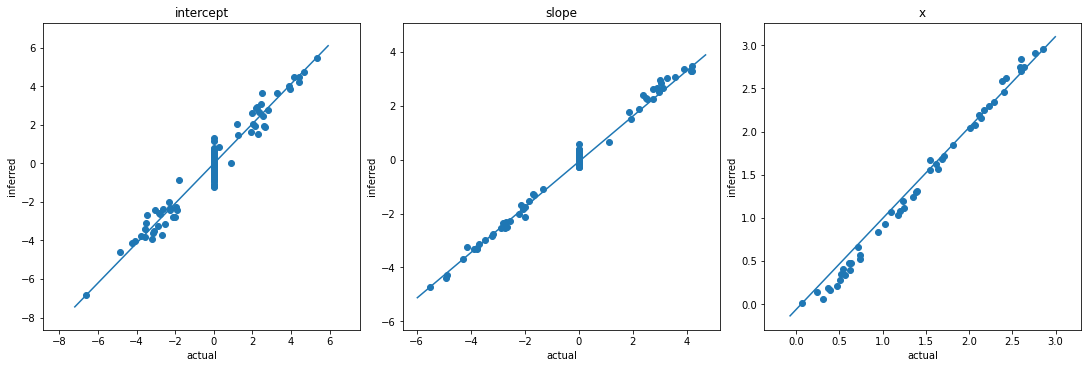

In [28]:
parameter_values = la.qa.cookbooks.check_parameters(la.qa.cookbooks.gather_parameters(["intercept", "slope", "x"], model_gs, observed))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

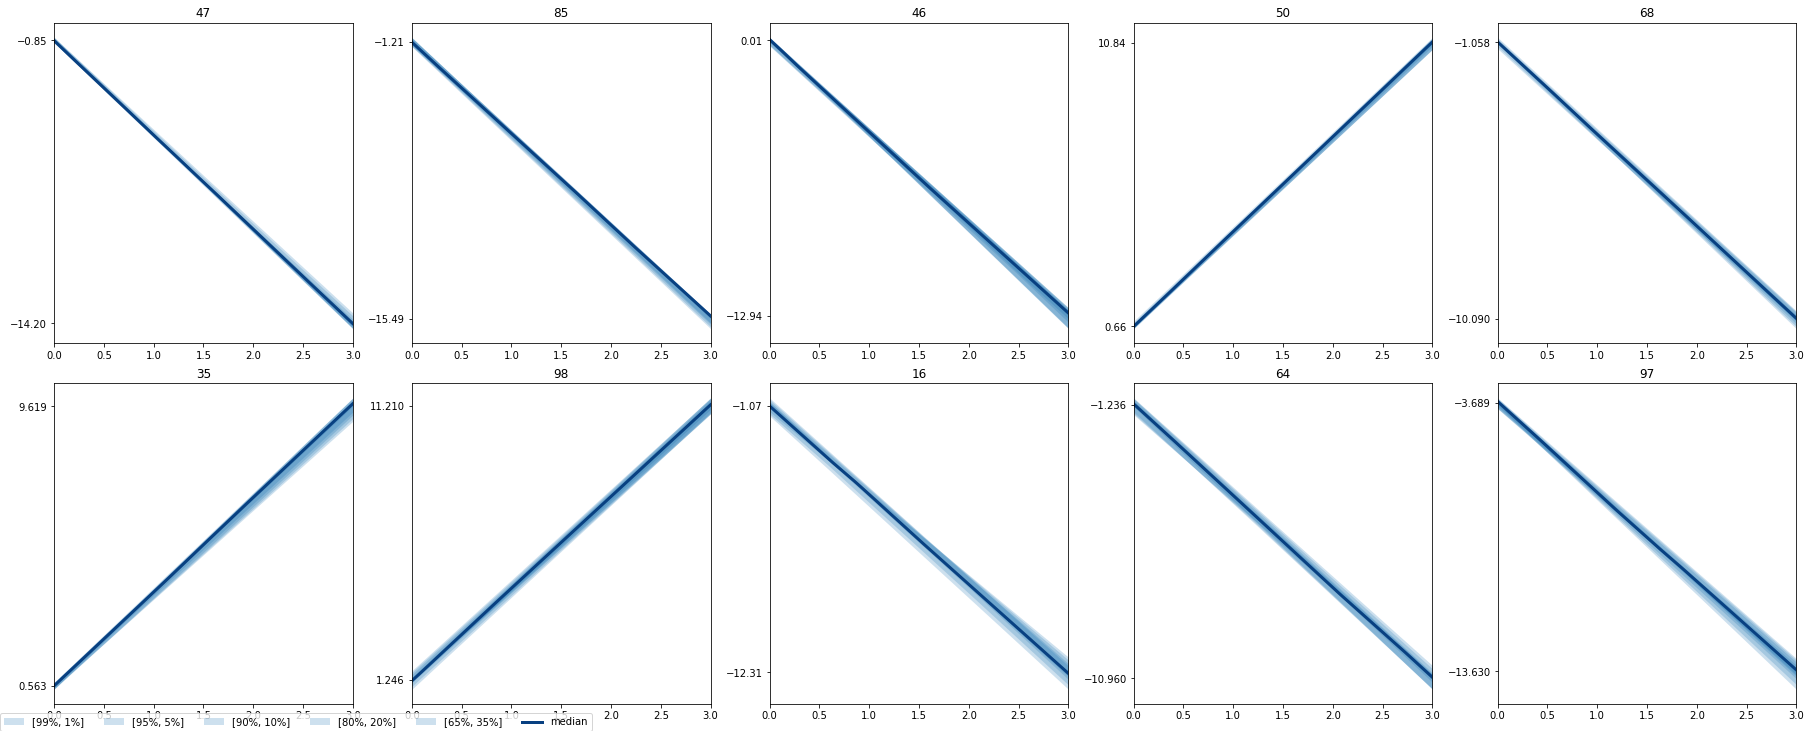

In [29]:
z.empirical = xr.DataArray(observation_value)
x.distribution = la.distributions.Uniform(0., 3.)
causal = la.posterior.scalar.ScalarVectorCausal(x, observation, observed = observed)
causal.sample(10)
causal.sample_random(10)
causal.plot_features(observation.p.loc);

## Linear regression with variational inference and amortized latent x

In [29]:
amortization_input = la.Fixed(observation_value, label = "observed")
nn = la.amortization.Encoder(amortization_input, x)


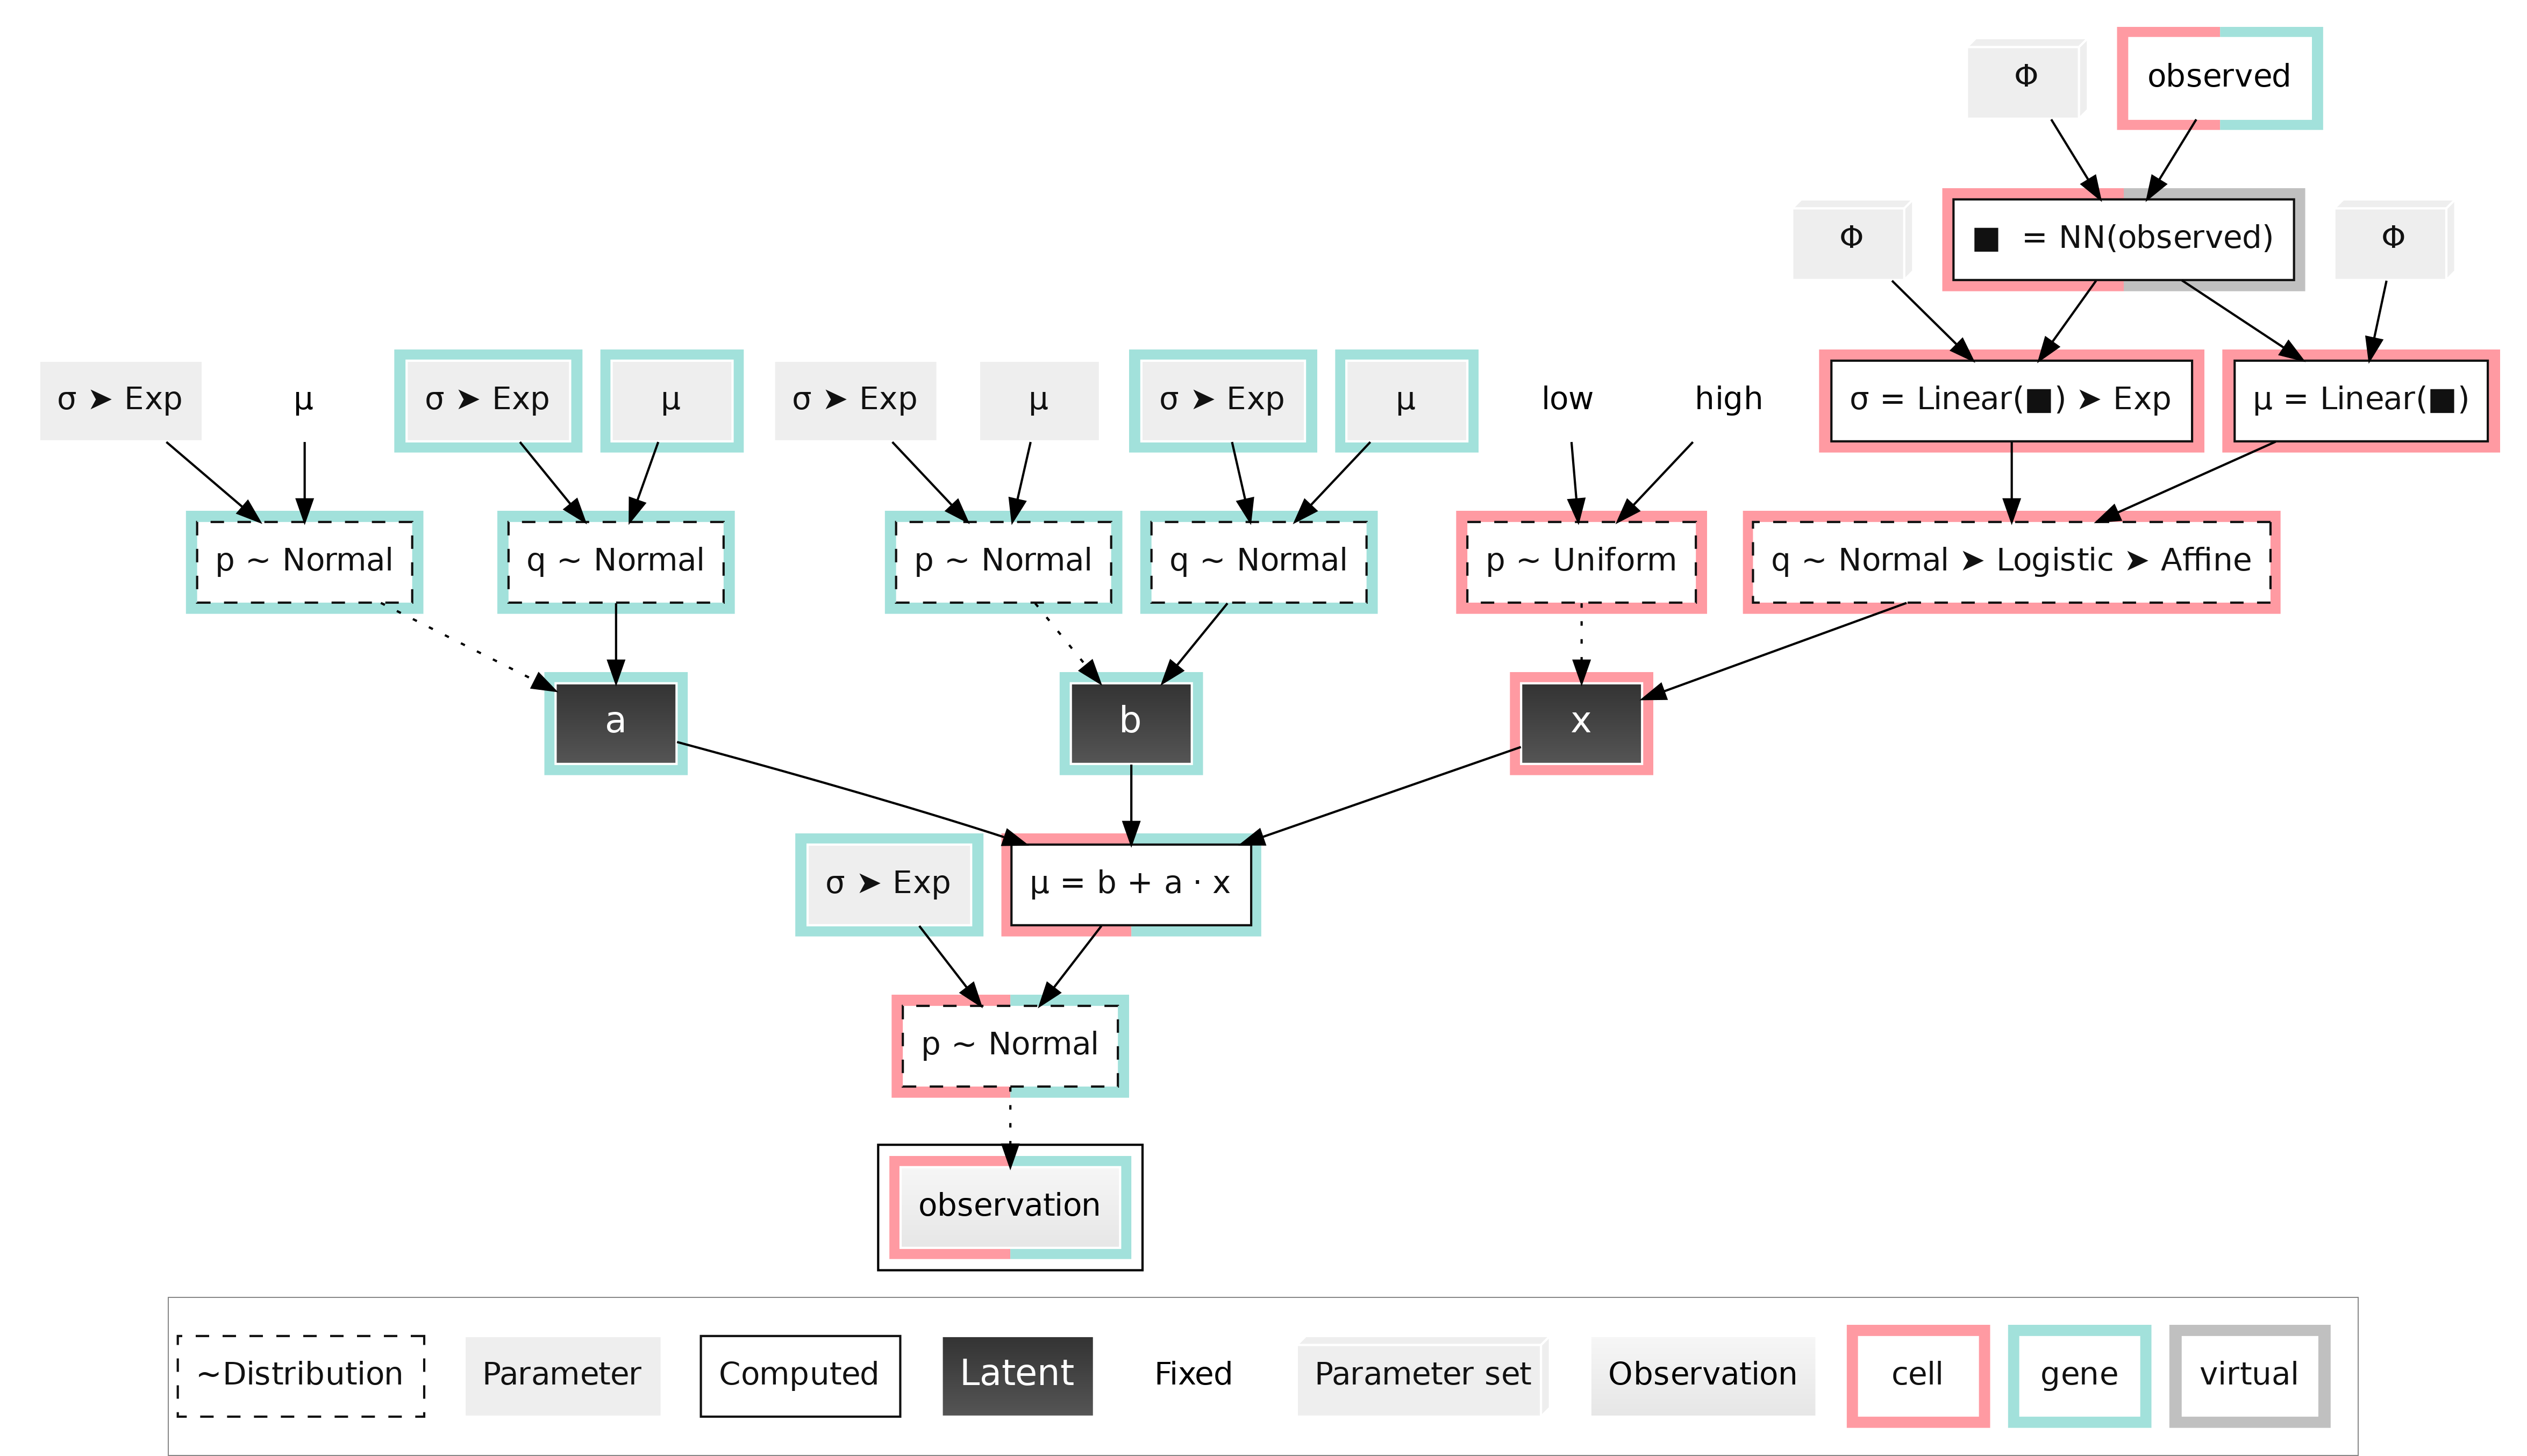

In [30]:
model = la.Model(observation)
model.plot()

  0%|                                                                                                         …

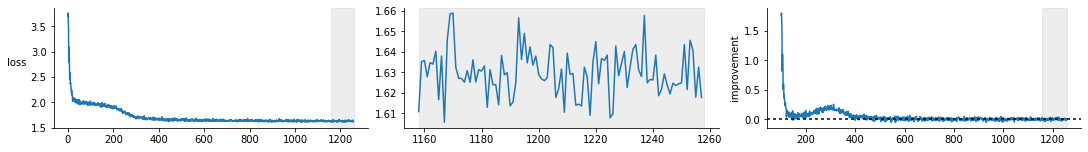

In [31]:
inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.05))
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(3000)
trace.plot();

In [32]:
observed = la.posterior.Posterior(observation)
observed.sample(10, subsample_n = 3)

  0%|          | 0/10 [00:00<?, ?it/s]

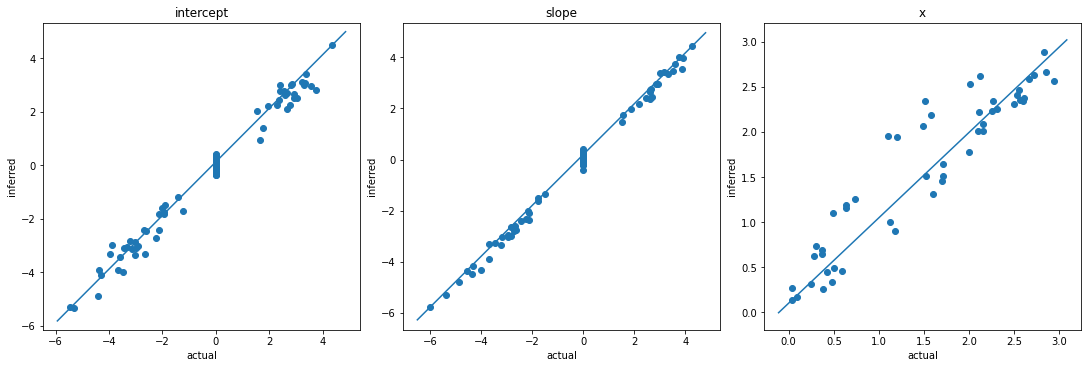

In [33]:
parameter_values = la.qa.cookbooks.check_parameters(la.qa.cookbooks.gather_parameters(["intercept", "slope", "x"], model_gs, observed))

<AxesSubplot:xlabel='gene', ylabel='cell'>

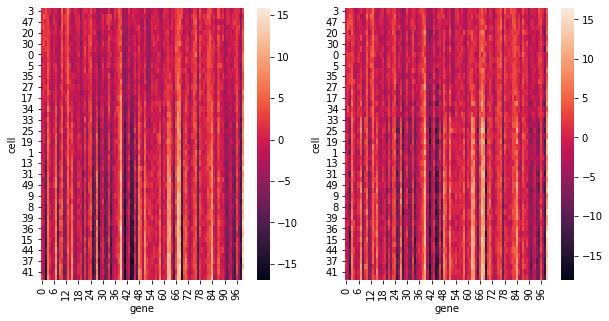

In [34]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10, 5))
cell_order = model_gs.find("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax = ax0)
modelled_value = observed.samples[observation.p].sel(sample = 0).to_pandas()
sns.heatmap(modelled_value.loc[cell_order], ax = ax1)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

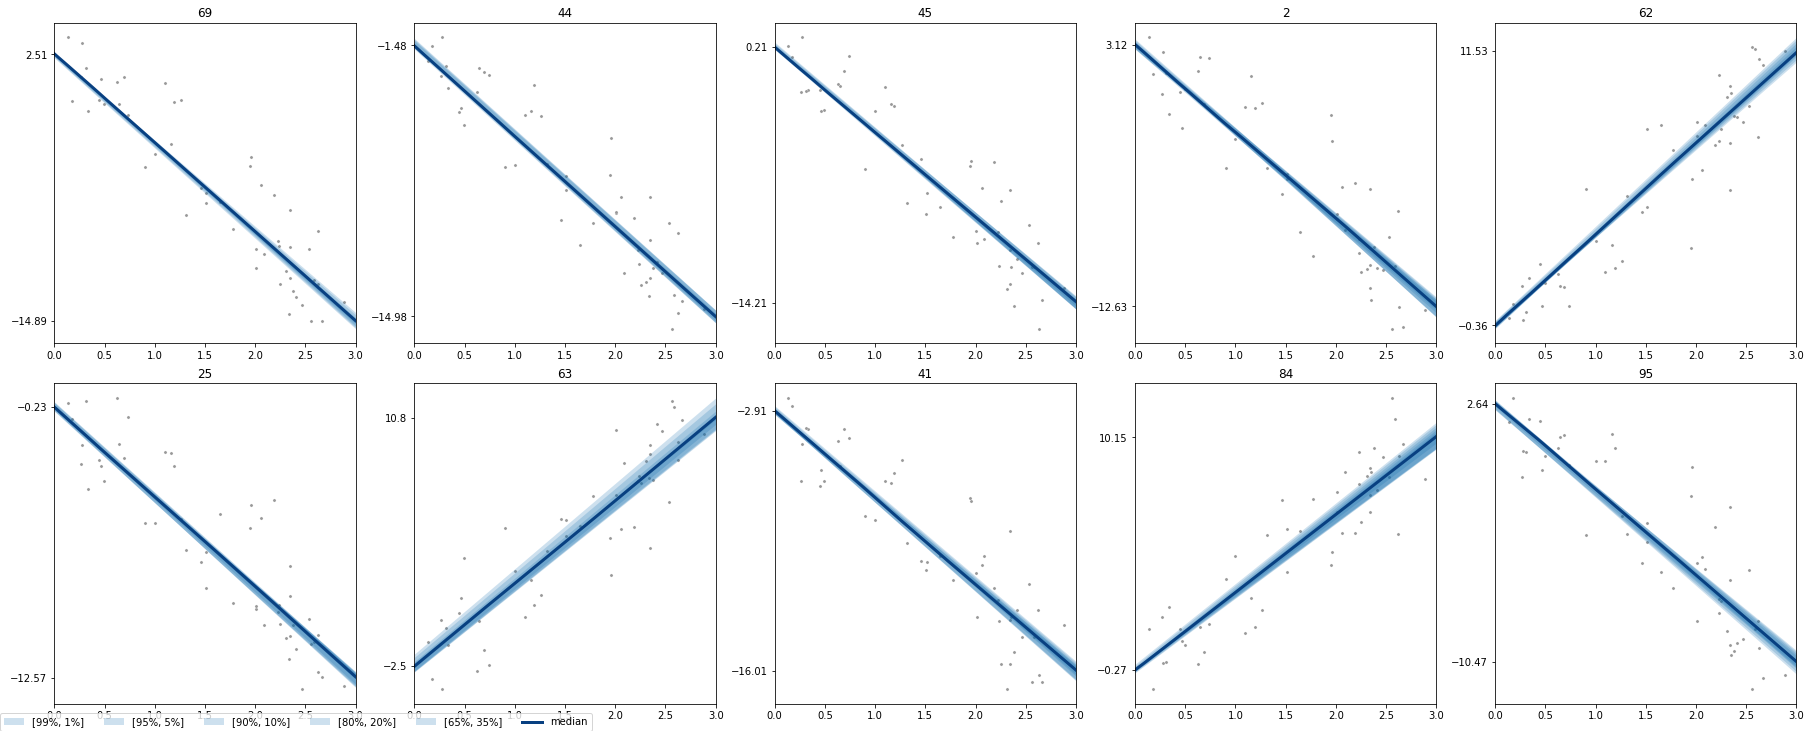

In [35]:
z.empirical = xr.DataArray(observation_value)
x.distribution = la.distributions.Uniform(0., 3.)
causal = la.posterior.scalar.ScalarVectorCausal(x, observation, observed = observed)
causal.sample(10)
causal.sample_random(10)
causal.plot_features();